<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

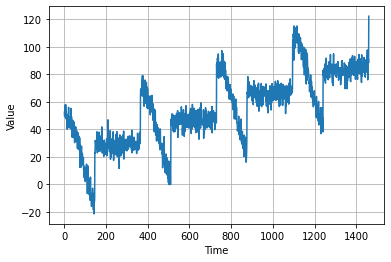

In [2]:
# Set the dataset
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)

In [0]:
# Split dataset into training and validation sets
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Set the constans that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define the windowed_dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
# Create the dataset
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Buld the 2 RNN layer model
model = tf.keras.models.Sequential([
  # Expand 1 dimentional data to RNN input data size (batch size, #time steps, #dim)
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  # Defaul activation function in the RNN layer is tanh and output values between -1 to 1
  # so, x scal up to multiply by 100 and speed up learning
  tf.keras.layers.Lambda(lambda x: x * 100.0)   
])

# Set the learning rate by callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(), # Huber loss: less sensitive to outliers
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1,
    callbacks=[lr_schedule]
)

Epoch 1/100
8/8 [==============================] - 0s 30ms/step - loss: 45.9725 - mae: 46.4725 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 45.5981 - mae: 46.0981 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 45.0004 - mae: 45.5004 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 44.2533 - mae: 44.7532 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 43.3793 - mae: 43.8791 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 42.3862 - mae: 42.8862 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 41.2680 - mae: 41.7680 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 40.0055 - mae: 40.5055 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 38.5879 - mae: 39.0879 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

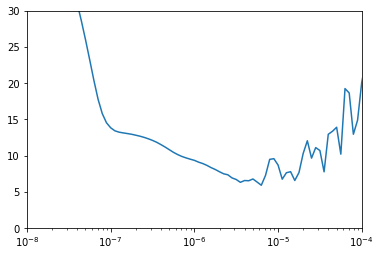

In [6]:
# Plot the loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# Stable point -- 5e-5

In [7]:
# Retrain the DNN model with stable learning rate point

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    dataset,
    epochs=400,
    verbose=1
)

Epoch 1/400
8/8 [==============================] - 0s 23ms/step - loss: 81.7535 - mae: 82.2535
Epoch 2/400
8/8 [==============================] - 0s 24ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 23ms/step - loss: 15.9200 - mae: 16.4143
Epoch 4/400
8/8 [==============================] - 0s 23ms/step - loss: 12.2878 - mae: 12.7812
Epoch 5/400
8/8 [==============================] - 0s 26ms/step - loss: 10.1482 - mae: 10.6384
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 16.5448 - mae: 17.0381
Epoch 7/400
8/8 [==============================] - 0s 23ms/step - loss: 13.6322 - mae: 14.1257
Epoch 8/400
8/8 [==============================] - 0s 25ms/step - loss: 10.7439 - mae: 11.2364
Epoch 9/400
8/8 [==============================] - 0s 25ms/step - loss: 8.8818 - mae: 9.3723
Epoch 10/400
8/8 [==============================] - 0s 27ms/step - loss: 10.2031 - mae: 10.6949
Epoch 11/400
8/8 [==============================] -

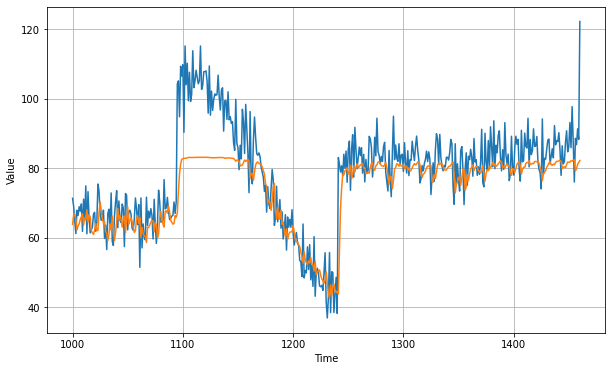

In [11]:
# Plot results
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.837631

<Figure size 432x288 with 0 Axes>

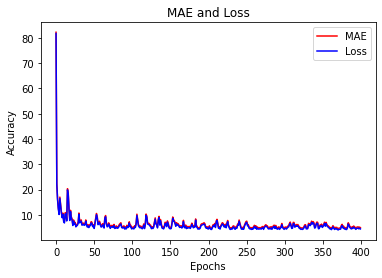

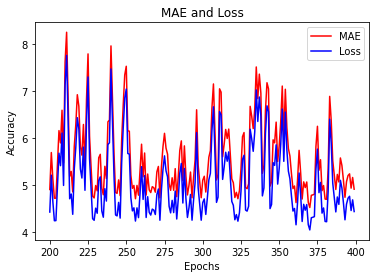

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()